In [1]:
import pandas as pd
import matplotlib.pylab as plt
import requests
import numpy as np

import missingno as msno
import datetime

In [2]:
site = '11161000'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2023-09-30T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_SC_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_SC_raw.head()

,value,qualifiers,dateTime
0,4.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,4.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,3.90,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,3.70,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,3.20,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [3]:
site = '11160500'
code = '00060'
startDT = '1987-10-01T00:00:00.000-07:00'
endDT = '2023-09-30T00:00:00.000-07:00'

usgs_water_api = ("https://waterservices.usgs.gov/nwis/iv/?format=json&sites=" + site +  "&parameterCd=" + code + 
                  "&siteStatus=all&startDT=" + startDT + "&endDT=" + endDT)
api_response = requests.get(usgs_water_api)

water_data = api_response.json()
data_only = water_data['value']['timeSeries'][0]['values'][0]['value']

streamflow_BT_raw = pd.DataFrame(data_only).sort_values('dateTime')
streamflow_BT_raw.head()


,value,qualifiers,dateTime
0,9.40,"[A, [91]]",1987-10-01T00:15:00.000-07:00
1,9.40,"[A, [91]]",1987-10-01T00:30:00.000-07:00
2,9.40,"[A, [91]]",1987-10-01T00:45:00.000-07:00
3,9.40,"[A, [91]]",1987-10-01T01:00:00.000-07:00
4,9.40,"[A, [91]]",1987-10-01T01:15:00.000-07:00


In [4]:
# combine streamflow data into one df

def process_streamflow(streamflow_data):
    #create datetime index
    streamflow_data.index = pd.to_datetime([x[0:-6] for x in streamflow_data['dateTime']]) 

    # convert data to PST (-08:00) 
    streamflow_data['tz'] = [x[-6::] for x in streamflow_data['dateTime']]
    streamflow_data.loc[streamflow_data.tz == '-07:00', :].index = streamflow_data.loc[streamflow_data.tz == '-07:00', :].index - pd.Timedelta(1, 'hour')

    #rename cols
    col_mapper = {'value': 'q_cfs', 'qualifiers': 'code'}
    streamflow_data.rename(col_mapper, axis=1, inplace=True) # rename cols

    #cfs to numeric 
    streamflow_data['q_cfs'] = streamflow_data['q_cfs'].apply(pd.to_numeric)

    # resample to 15 min to account for timechange dupes
    streamflow_data_resample = streamflow_data.resample('15min').agg({'q_cfs': 'mean',
                                                                     'code': 'first', 
                                                                     'dateTime': 'first', 
                                                                     'tz': 'first'})
    return streamflow_data_resample


streamflow_BT = process_streamflow(streamflow_BT_raw)
streamflow_SC = process_streamflow(streamflow_SC_raw)


streamflow = pd.merge(streamflow_BT, streamflow_SC, how='outer', left_index=True, right_index=True, suffixes=['_BT', '_SC'])

streamflow.head()

,q_cfs_BT,code_BT,dateTime_BT,tz_BT,q_cfs_SC,code_SC,dateTime_SC,tz_SC
1987-10-01 00:15:00,9.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00
1987-10-01 00:30:00,9.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00
1987-10-01 00:45:00,9.4,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00,3.9,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00
1987-10-01 01:00:00,9.4,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00,3.7,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00
1987-10-01 01:15:00,9.4,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00,3.2,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00


In [5]:
# noaa_api = 'https://www.ncei.noaa.gov/access/past-weather/USC00040673/data.json'
# response = requests.get(noaa_api)
# rain_data = response.json()
# weather_BL = pd.DataFrame(rain_data['timeseries'])

# noaa_api = 'https://www.ncei.noaa.gov/access/past-weather/USC00047916/data.json'
# response = requests.get(noaa_api)
# rain_data = response.json()
# weather_SC = pd.DataFrame(rain_data['timeseries'])

In [6]:
cdec_bl_api = 'https://cdec.water.ca.gov/dynamicapp/req/JSONDataServlet?Stations=BLN&SensorNums=16&dur_code=E&Start=1997-12-10&End=2024-06-19'

response = requests.get(cdec_bl_api)
rain_data = response.json()


In [7]:
event_rain = pd.DataFrame(rain_data)
event_rain['dt'] = pd.to_datetime(event_rain['date'])
event_rain['inc'] = event_rain['value'].diff()

event_rain.sort_values('inc')
event_rain_cleaned = event_rain.loc[event_rain['dt'] > pd.to_datetime('2008-10-01'), :]
event_rain_cleaned.loc[event_rain_cleaned.inc < 0, 'inc'] = 0 #negative increments are when tip resets to zero
event_rain_cleaned.loc[event_rain_cleaned.inc >10, 'inc'] = 0 # greater than 10 are when cumulative precip jumps back up to cumulative after data drop

(np.float64(14153.0), np.float64(19935.0))

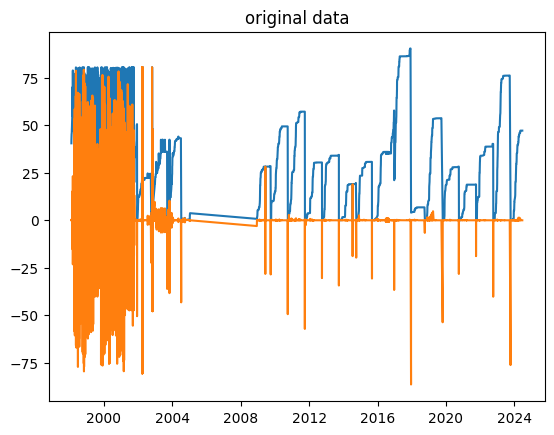

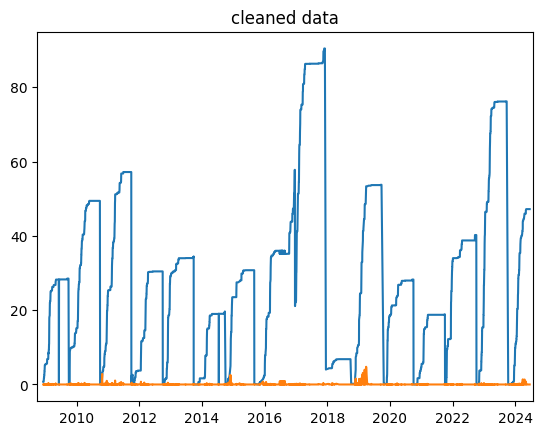

In [8]:
##use this plot code to explore data and iterate on cleaning above. 
f, ax = plt.subplots(1, 1)
ax.plot(event_rain.dt, event_rain['value'])
ax.plot(event_rain.dt, event_rain['inc'])
ax.set_title('original data')

f, ax2 = plt.subplots(1, 1)
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned['value'])
ax2.plot(event_rain_cleaned.dt, event_rain_cleaned.inc)
ax2.set_title('cleaned data')
ax2.set_xlim(pd.to_datetime('2008-10-01'), pd.to_datetime('2024-07-31'))

# ax2.xlim(pd.to_datetime('2018-08-01'), pd.to_datetime('2019-06-01'))
# ax2.ylim(-1, 5)

In [9]:
event_rain_cleaned

,stationId,durCode,SENSOR_NUM,sensorType,date,obsDate,value,dataFlag,units,dt,inc
16292,BLN,E,16,RAINTIP,2008-12-10 3:34,2008-12-10 3:34,0.71,,INCHES,2008-12-10 03:34:00,0.0
16293,BLN,E,16,RAINTIP,2008-12-10 15:34,2008-12-10 15:34,0.71,,INCHES,2008-12-10 15:34:00,0.0
16294,BLN,E,16,RAINTIP,2008-12-11 3:34,2008-12-11 3:34,0.71,,INCHES,2008-12-11 03:34:00,0.0
16295,BLN,E,16,RAINTIP,2008-12-11 15:34,2008-12-11 15:34,0.71,,INCHES,2008-12-11 15:34:00,0.0
16296,BLN,E,16,RAINTIP,2008-12-12 3:34,2008-12-12 3:34,0.71,,INCHES,2008-12-12 03:34:00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
36482,BLN,E,16,RAINTIP,2024-6-12 11:01,2024-6-12 11:01,47.19,,INCHES,2024-06-12 11:01:00,0.0
36483,BLN,E,16,RAINTIP,2024-6-12 23:01,2024-6-12 23:01,47.19,,INCHES,2024-06-12 23:01:00,0.0
36484,BLN,E,16,RAINTIP,2024-6-15 11:01,2024-6-15 11:01,47.19,,INCHES,2024-06-15 11:01:00,0.0
36485,BLN,E,16,RAINTIP,2024-6-17 23:01,2024-6-17 23:01,47.19,,INCHES,2024-06-17 23:01:00,0.0


In [10]:
event_rain_cleaned.index = event_rain_cleaned.dt
rain_15min = event_rain_cleaned[['inc']].resample('15min').sum()
rain_15min.rename({'inc': 'precip_in'}, axis=1, inplace=True)
rain_15min.describe()

,precip_in
count,544255.000000
mean,0.001217
std,0.018257
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,4.760000


In [11]:
# combine all data into one df 

hydro_data = pd.merge(rain_15min, streamflow, how='outer', left_index=True, right_index=True)
hydro_data.head()

,precip_in,q_cfs_BT,code_BT,dateTime_BT,tz_BT,q_cfs_SC,code_SC,dateTime_SC,tz_SC
1987-10-01 00:15:00,NaN,9.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:15:00.000-07:00,-07:00
1987-10-01 00:30:00,NaN,9.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00,4.4,"[A, [91]]",1987-10-01T00:30:00.000-07:00,-07:00
1987-10-01 00:45:00,NaN,9.4,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00,3.9,"[A, [91]]",1987-10-01T00:45:00.000-07:00,-07:00
1987-10-01 01:00:00,NaN,9.4,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00,3.7,"[A, [91]]",1987-10-01T01:00:00.000-07:00,-07:00
1987-10-01 01:15:00,NaN,9.4,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00,3.2,"[A, [91]]",1987-10-01T01:15:00.000-07:00,-07:00


In [12]:
# clean data

hydro_data.isna().sum()

precip_in      743149
q_cfs_BT        35083
code_BT         35083
dateTime_BT     35083
tz_BT           35083
q_cfs_SC        62655
code_SC         62655
dateTime_SC     62655
tz_SC           62655
dtype: int64

<Axes: >

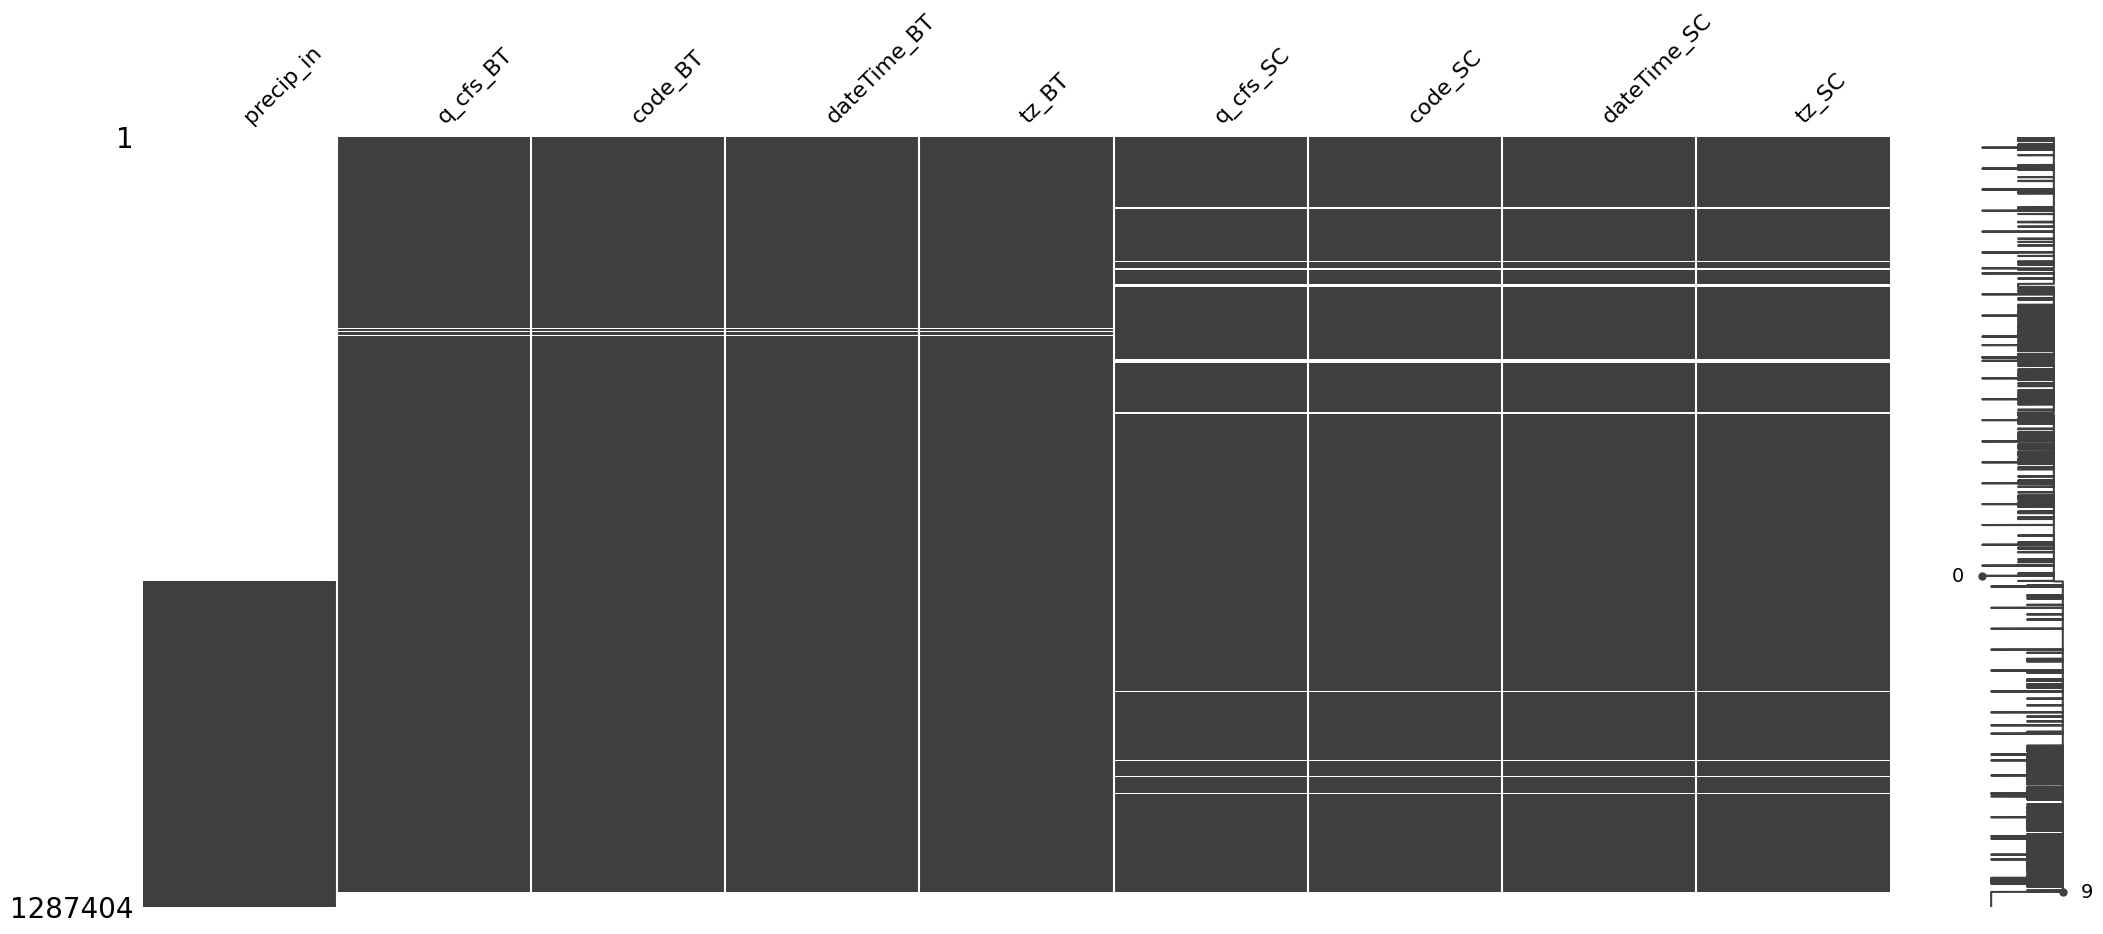

In [13]:
msno.matrix(hydro_data)

precip_in      6734
q_cfs_BT       1262
code_BT        1262
dateTime_BT    1262
tz_BT          1262
q_cfs_SC       6771
code_SC        6771
dateTime_SC    6771
tz_SC          6771
dtype: int64

<Axes: >

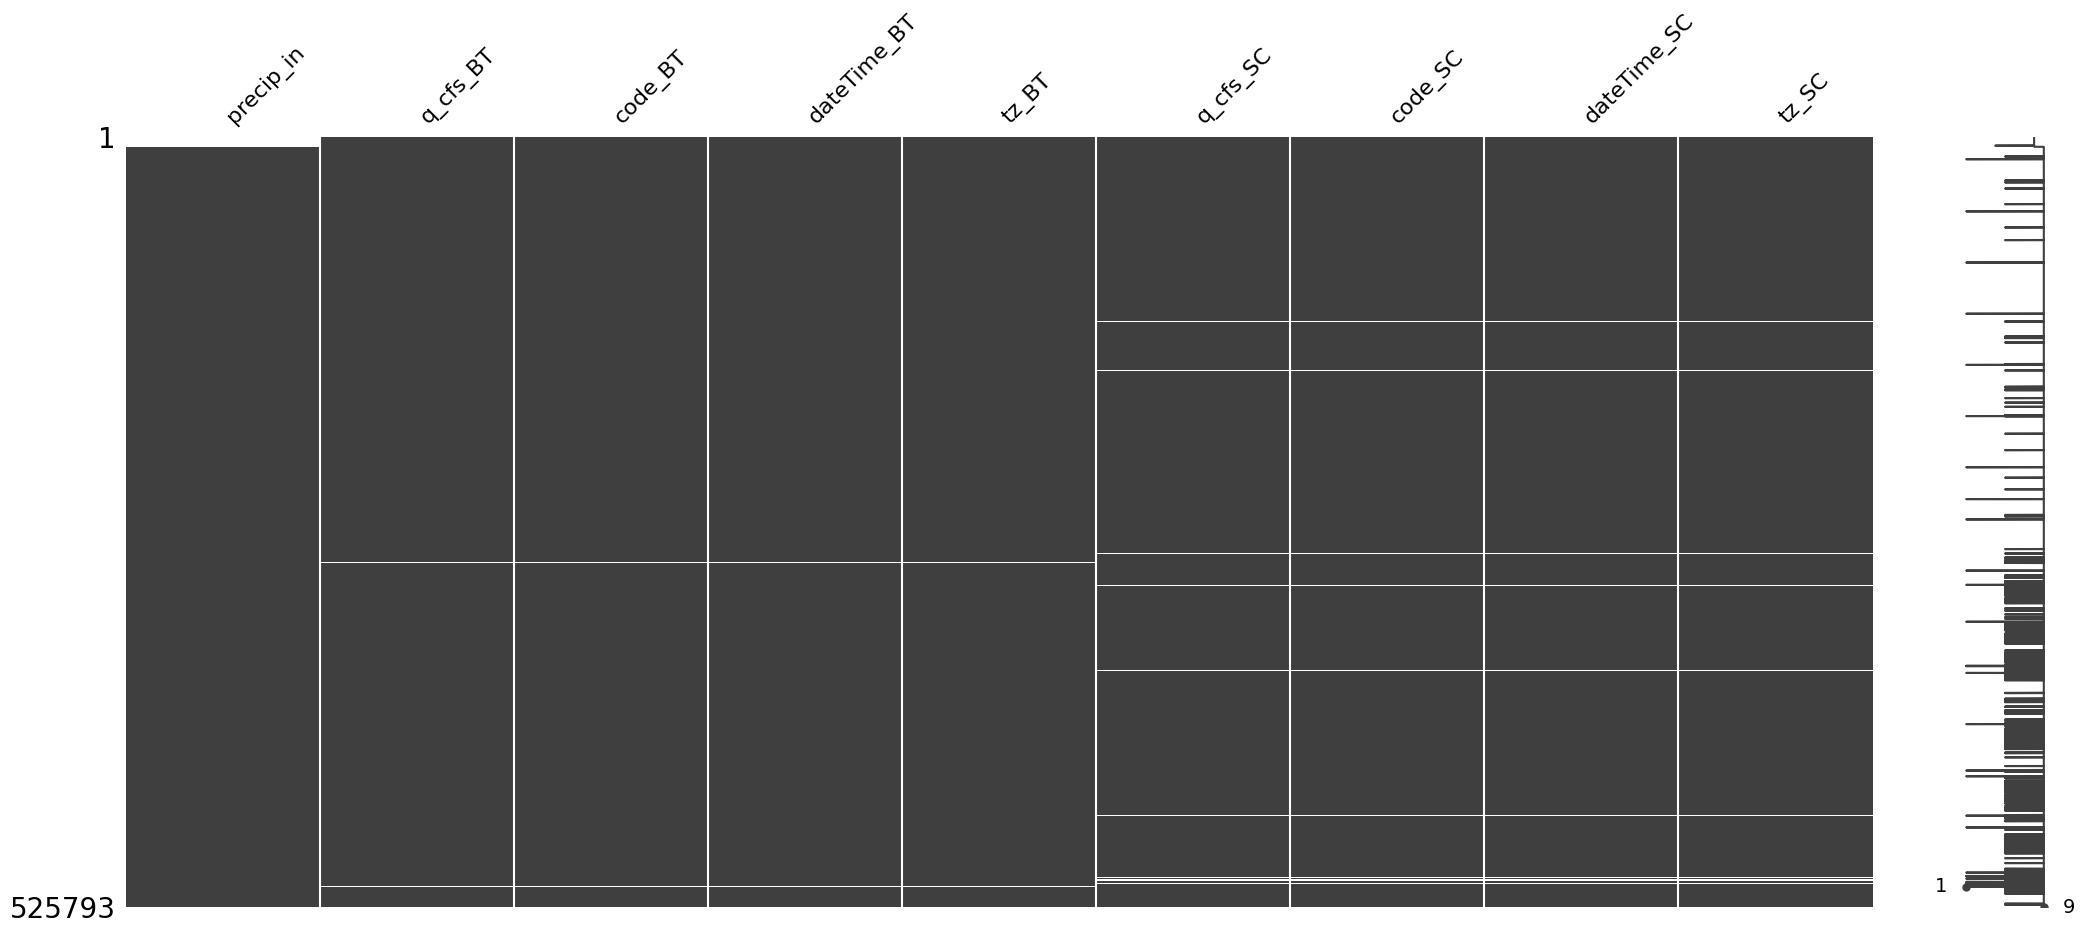

In [14]:
## keep only wy 2008 - 2023
hydro_data = hydro_data.loc[(hydro_data.index >= pd.to_datetime('2008-10-01')) & (hydro_data.index <= pd.to_datetime('2023-09-30'))]
display(hydro_data.isna().sum())
msno.matrix(hydro_data)

(20380320.0, 28267200.0)

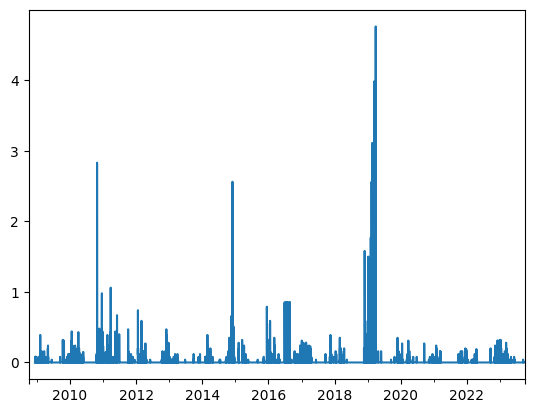

In [15]:
hydro_data.precip_in.plot()
plt.xlim(pd.to_datetime('2008-10-01'), pd.to_datetime('2023-09-30'))

In [16]:
### fill precip with zero, incremental rainfall
hydro_data.precip_in = hydro_data.precip_in.fillna(0)
display(hydro_data.isna().sum())



precip_in         0
q_cfs_BT       1262
code_BT        1262
dateTime_BT    1262
tz_BT          1262
q_cfs_SC       6771
code_SC        6771
dateTime_SC    6771
tz_SC          6771
dtype: int64

precip_in      float64
q_cfs_BT       float64
code_BT         object
dateTime_BT     object
tz_BT           object
q_cfs_SC       float64
code_SC         object
dateTime_SC     object
tz_SC           object
dtype: object

<Axes: >

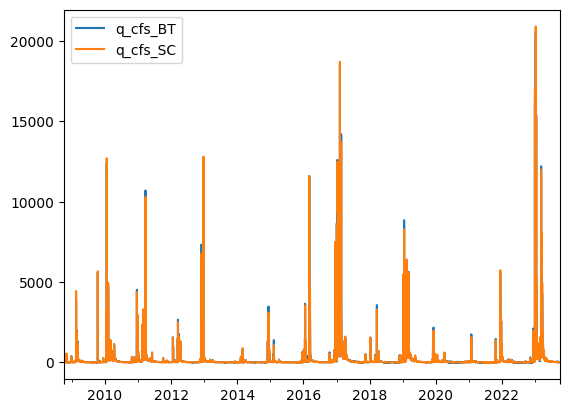

In [17]:
## code and datetime not important for modeling, so look at discharge
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].apply(pd.to_numeric)
display(hydro_data.dtypes)
hydro_data.plot(y=['q_cfs_BT', 'q_cfs_SC'])
# plt.yscale('log')

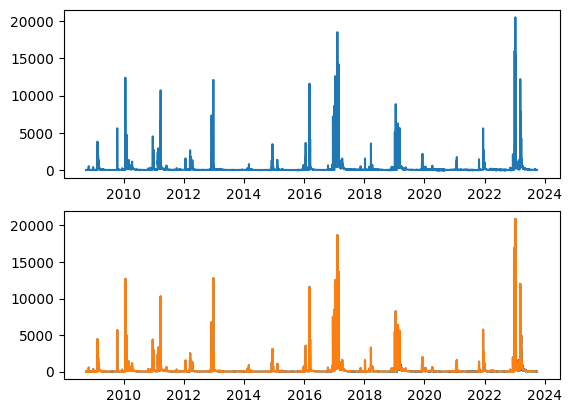

In [18]:
hydro_data[['q_cfs_BT_int', 'q_cfs_SC_int']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].interpolate()
# hydro_data[['q_cfs_BT', 'q_cfs_SC']] = hydro_data[['q_cfs_BT', 'q_cfs_SC']].fillna(-999)
f, ax = plt.subplots(2, 1)
ax[0].plot(hydro_data[['q_cfs_BT']])
# ax[0].plot(hydro_data.q_cfs_BT.isna() * 10000 - 5000, linestyle='', marker='.')
ax[1].plot(hydro_data[['q_cfs_SC', 'q_cfs_SC_int']])
# ax[0].set_yscale('log')
# ax[0].set_xlim(pd.to_datetime('2018-04-01'), pd.to_datetime('2018-05-01'))

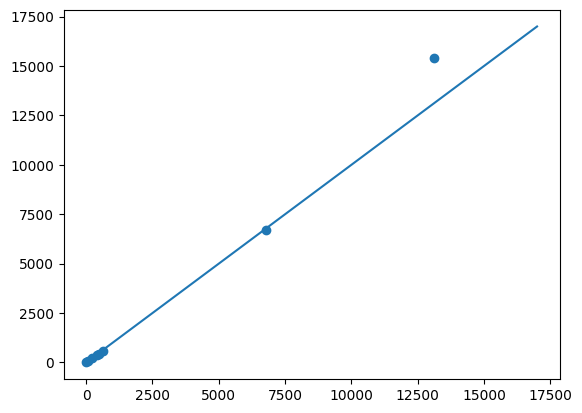

In [19]:
## compare interpolated

no_SC = hydro_data.loc[hydro_data.q_cfs_SC.isna(), :].describe()
plt.scatter(no_SC.q_cfs_SC_int, no_SC.q_cfs_BT)
plt.plot([0, 17000], [0, 17000])


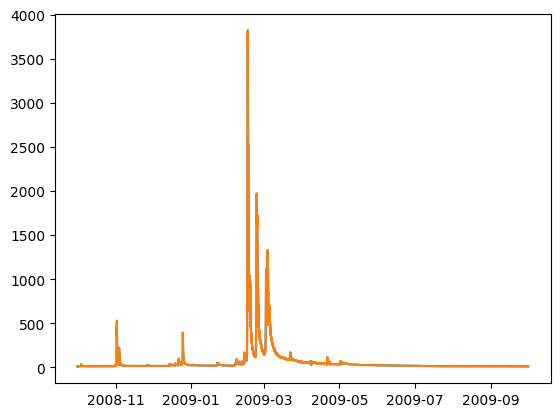

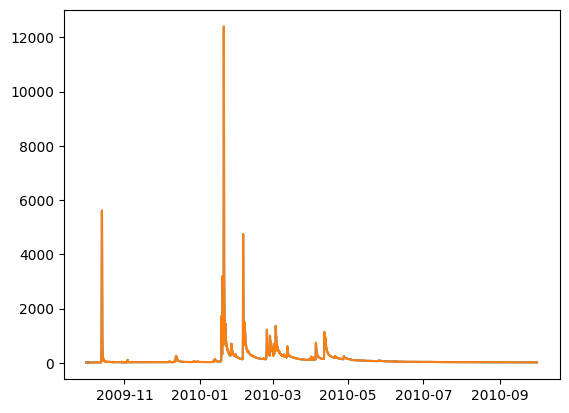

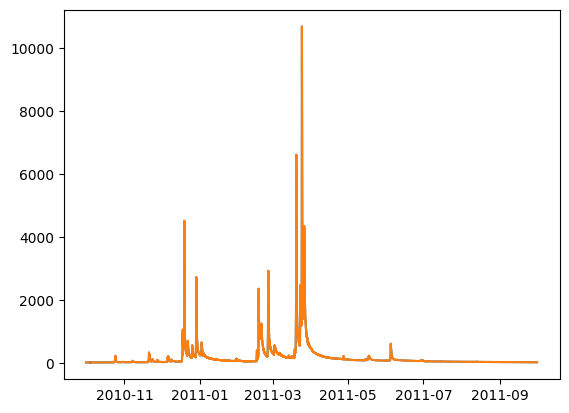

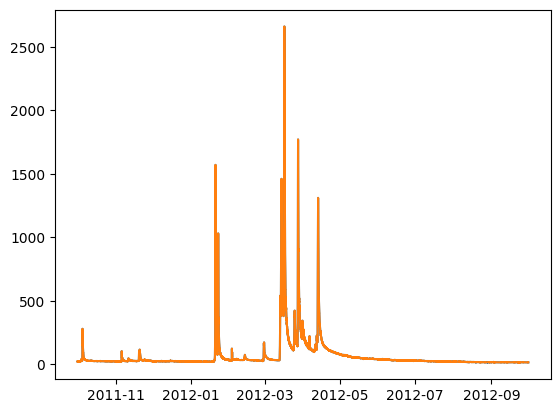

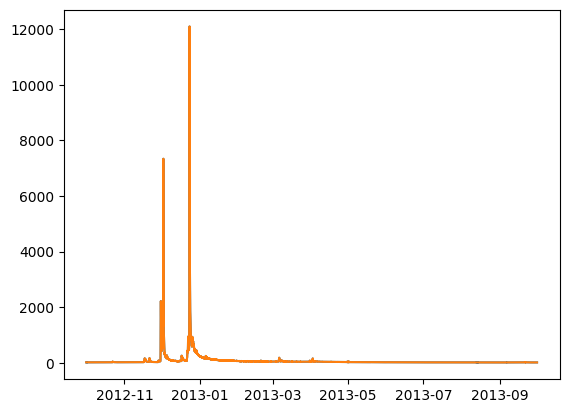

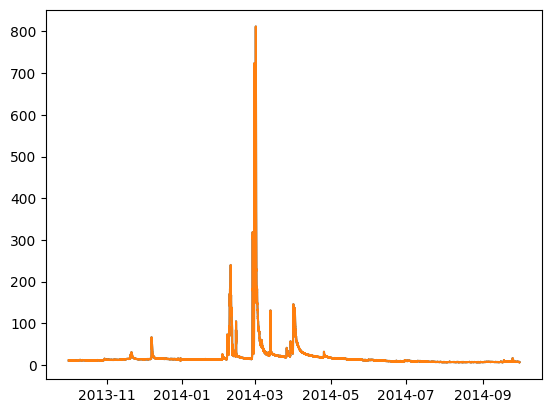

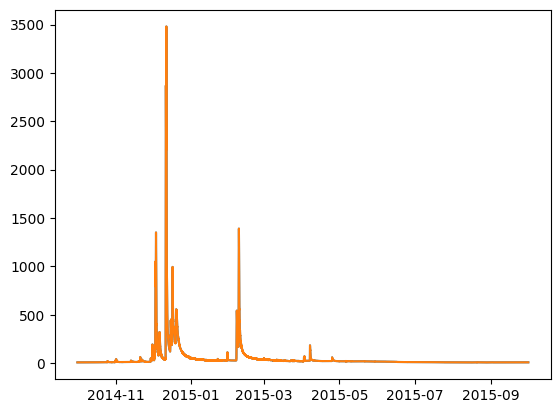

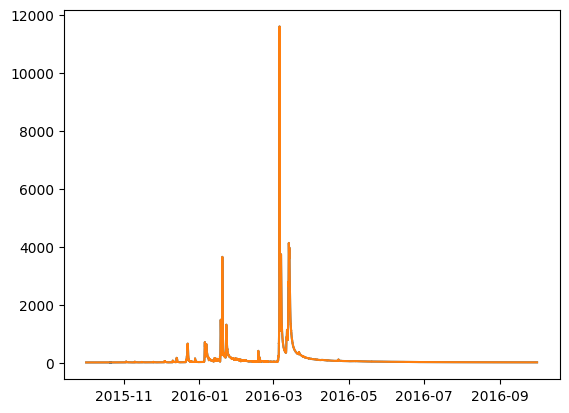

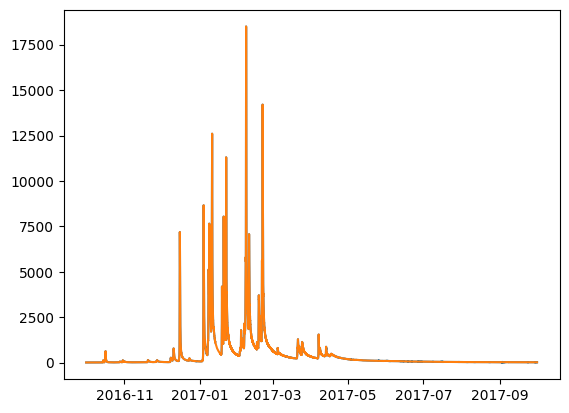

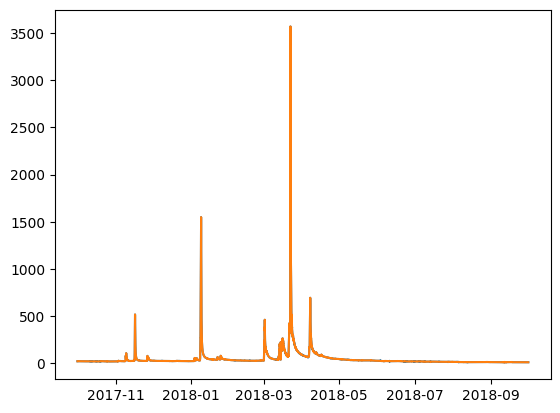

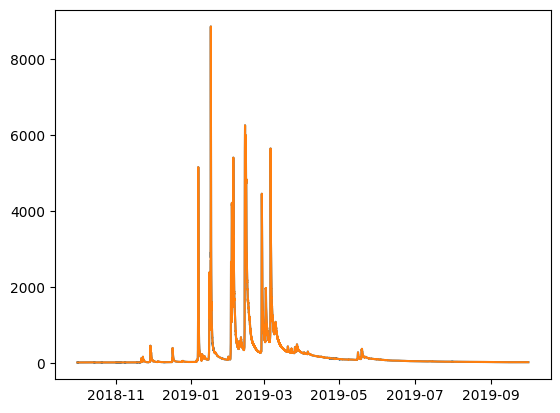

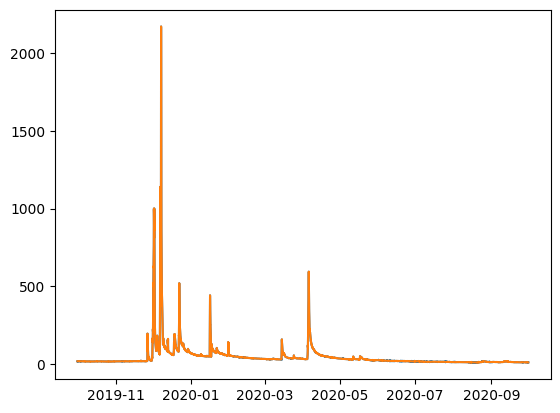

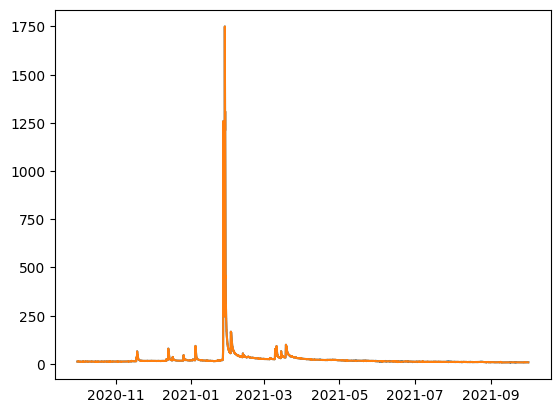

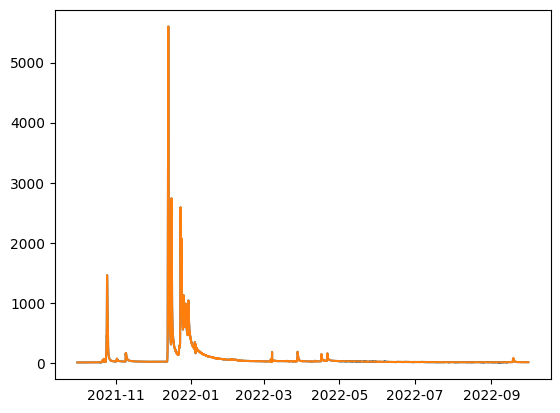

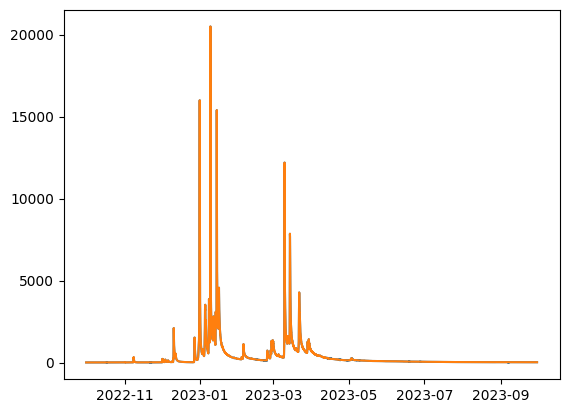

In [20]:
### plot each water year so they don't look crazy

hydro_data['cy'] = hydro_data.index.year
hydro_data['month'] = hydro_data.index.month

hydro_data['wy'] = hydro_data.cy
hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'wy'] = hydro_data.loc[hydro_data['month'].isin([10, 11, 12]), 'cy'] + 1

for wy in hydro_data['wy'].unique():
    f, ax = plt.subplots(1, 1)
    data_wy = hydro_data.loc[hydro_data['wy'] == wy, :]
    ax.plot(data_wy.index, data_wy[['q_cfs_BT', 'q_cfs_BT_int']])

In [21]:
#how many consecutive missing q values?
a = hydro_data[['q_cfs_BT', 'q_cfs_SC']].isna()
df1 = a.cumsum()-a.cumsum().where(~a).ffill().fillna(0).astype(int)
df1.max()/ 4 #hours

q_cfs_BT     24.00
q_cfs_SC    115.75
dtype: float64

In [22]:
hydro_data.isna().sum()
hydro_data_clean = hydro_data.drop(['q_cfs_BT', 'code_BT', 'dateTime_BT', 'q_cfs_SC', 'code_SC', 'dateTime_SC', 'tz_BT', 'tz_SC'], axis=1)

hydro_data_clean

,precip_in,q_cfs_BT_int,q_cfs_SC_int,cy,month,wy
2008-10-01 00:00:00,0.0,10.8,1.43,2008,10,2009
2008-10-01 00:15:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 00:30:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 00:45:00,0.0,10.8,1.26,2008,10,2009
2008-10-01 01:00:00,0.0,10.8,1.26,2008,10,2009
...,...,...,...,...,...,...
2023-09-29 23:00:00,0.0,26.6,17.20,2023,9,2023
2023-09-29 23:15:00,0.0,26.6,16.80,2023,9,2023
2023-09-29 23:30:00,0.0,26.6,16.80,2023,9,2023
2023-09-29 23:45:00,0.0,26.6,16.80,2023,9,2023


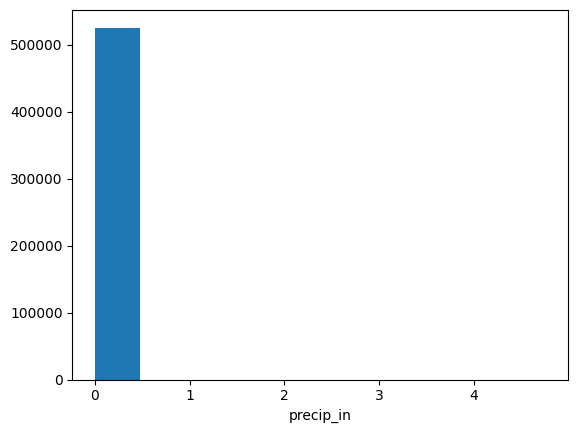

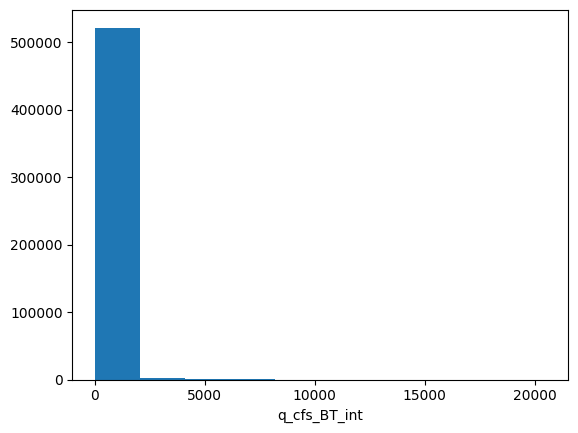

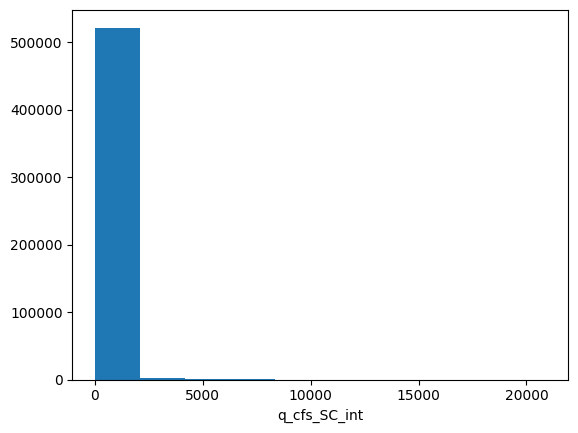

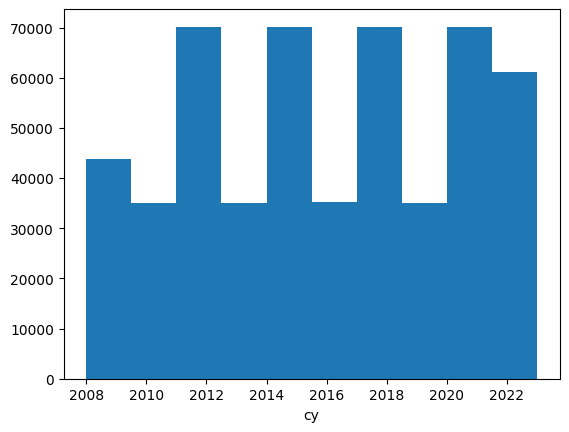

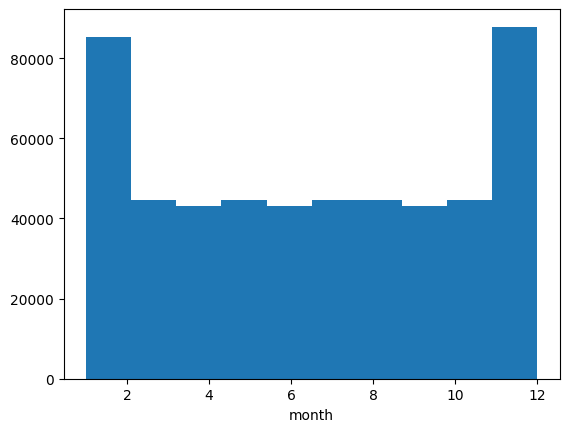

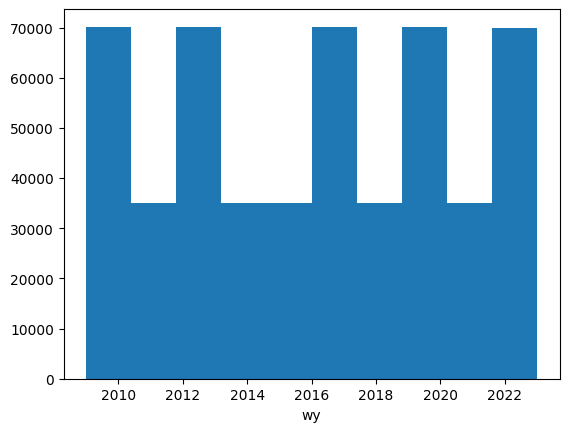

In [23]:
##outliers

for n in hydro_data_clean.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(hydro_data_clean[n])
    ax.set_xlabel(n)

# hydro_data_clean.head(20)

In [38]:
print('timestamp duplicates: ', hydro_data_clean.index.duplicated().sum())
display(hydro_data_clean.wy.value_counts())
display(hydro_data_clean.month.value_counts())

## no timestamp duplicates. Weird spikey histograms are binning issues. 

timestamp duplicates:  0


wy
2012    35136
2016    35136
2020    35136
2009    35040
2010    35040
2011    35040
2013    35040
2014    35040
2015    35040
2017    35040
2018    35040
2019    35040
2021    35040
2022    35040
2023    34945
Name: count, dtype: int64

month
10    44640
12    44640
1     44640
3     44640
5     44640
7     44640
8     44640
11    43200
4     43200
6     43200
9     43105
2     40608
Name: count, dtype: int64

In [61]:
## wildfires
wildfire_percent = {2017: 341.136 / 88320.0, # https://data-nifc.opendata.arcgis.com/datasets/nifc::historic-perimeters-combined-2000-2018-geomac/about
                   2020: 0.2} # https://www.cityofsantacruz.com/government/city-departments/water/water-quality/czu-fire-water-quality

# wildfire_percent = pd.DataFrame(wildfire_percent, index=[0, 1])
wildfire_percent[2017]

0.0038625000000000005

In [54]:
#drought data, SC county

drought_data = pd.read_csv('USDM-06087.csv', parse_dates=['ValidStart', 'ValidEnd'])
drought_data.rename({'ValidStart': 'week_start'}, axis=1, inplace=True)
drought_data.index = drought_data.week_start
drought_data = drought_data[['D0', 'D1', 'D2', 'D3', 'D4']].copy()
drought_data = drought_data.sort_index()
drought_data#.loc[pd.to_datetime('2008-10-01'), :]

,D0,D1,D2,D3,D4
week_start,,,,,
2000-01-04,0.0,0.0,0.0,0.0,0.0
2000-01-11,0.0,0.0,0.0,0.0,0.0
2000-01-18,0.0,0.0,0.0,0.0,0.0
2000-01-25,0.0,0.0,0.0,0.0,0.0
2000-02-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-05-21,0.0,0.0,0.0,0.0,0.0
2024-05-28,0.0,0.0,0.0,0.0,0.0
2024-06-04,0.0,0.0,0.0,0.0,0.0


In [79]:
#merge drought and wildfire data
drought_data_15min = drought_data.resample('15min').ffill()
data = pd.merge(hydro_data_clean, drought_data_15min, left_index=True, right_index=True, how='left')
data = pd.merge(hydro_data_clean, drought_data_15min, left_index=True, right_index=True, how='left')

for k in wildfire_percent.keys():
    data.loc[data['wy'] == k, 'wildfire_percent'] = wildfire_percent[k]

data[['wildfire_percent']] = data[['wildfire_percent']].fillna(0)

In [82]:
#final nan/duplicate checks

display(data.isna().sum())
print('duplicates: ', data.index.duplicated().sum())

precip_in           0
q_cfs_BT_int        0
q_cfs_SC_int        0
cy                  0
month               0
wy                  0
D0                  0
D1                  0
D2                  0
D3                  0
D4                  0
wildfire_percent    0
dtype: int64

duplicates:  0
